In [0]:
# This file performs data analysis on the UNSW HTTP dataset 
# and prints out graphs 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Move to drive
%cd drive
%cd 'My Drive'
%cd Oxford-Thesis

/content/drive
/content/drive/My Drive
/content/drive/My Drive/Oxford-Thesis


In [0]:
import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import warnings
import pickle
import numpy as np
import tensorflow as tf
import six 
import math
from tensorflow.python.training import moving_averages 
import pickle
import tensorflow.keras.backend as K
from sklearn.preprocessing import normalize
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

In [0]:
## Load in data
continuous_flows = []
with open('./embedding/UNSW-NB15/continuous1HTTPALL', 'rb') as fp:
  continuous_flows = pickle.load(fp)
  fp.close()
NUM_SCAN = 2073
NUM_FUZZ = 1087
NUM_ANALY = 558
NUM_BACK = 92
NUM_DOS = 1709
NUM_EXP = 11481
NUM_GEN = 1699
NUM_SHELL = 0
NUM_WORM = 148

In [0]:
## Name of each Malicious Flow 
flow_names = []
flow_names.append('Benign')
flow_names.append('Reconaissance Scans')
flow_names.append('Fuzzers')
flow_names.append('Analysis')
flow_names.append('Backdoors')
flow_names.append('DoS')
flow_names.append('Eploits')
flow_names.append('Generic')
flow_names.append('Shellcode')
flow_names.append('Worms')

## Get frequency of each network activity type
flow_frequencies = []
flow_frequencies.append(NUM_BENIGN)
flow_frequencies.append(UP_NUM_SCAN)
flow_frequencies.append(UP_NUM_ANALY)
flow_frequencies.append(UP_NUM_BACK)
flow_frequencies.append(UP_NUM_DOS)
flow_frequencies.append(UP_NUM_EXP)
flow_frequencies.append(UP_NUM_GEN)
flow_frequencies.append(UP_NUM_SHELL)
flow_frequencies.append(UP_NUM_WORM)
flow_frequencies, flow_names = zip(*sorted(zip(flow_frequencies, flow_names),reverse=True))

flow_frequencies = list(flow_frequencies)
flow_names = list(flow_names)

['Benign', 'Reconaissance Scans', 'Fuzzers', 'Analysis', 'Backdoors', 'DoS', 'Eploits', 'Generic', 'Shellcode', 'Worms']
[1290413, 176700, 31695, 33285, 207885, 373815, 50370, 22665, 390]


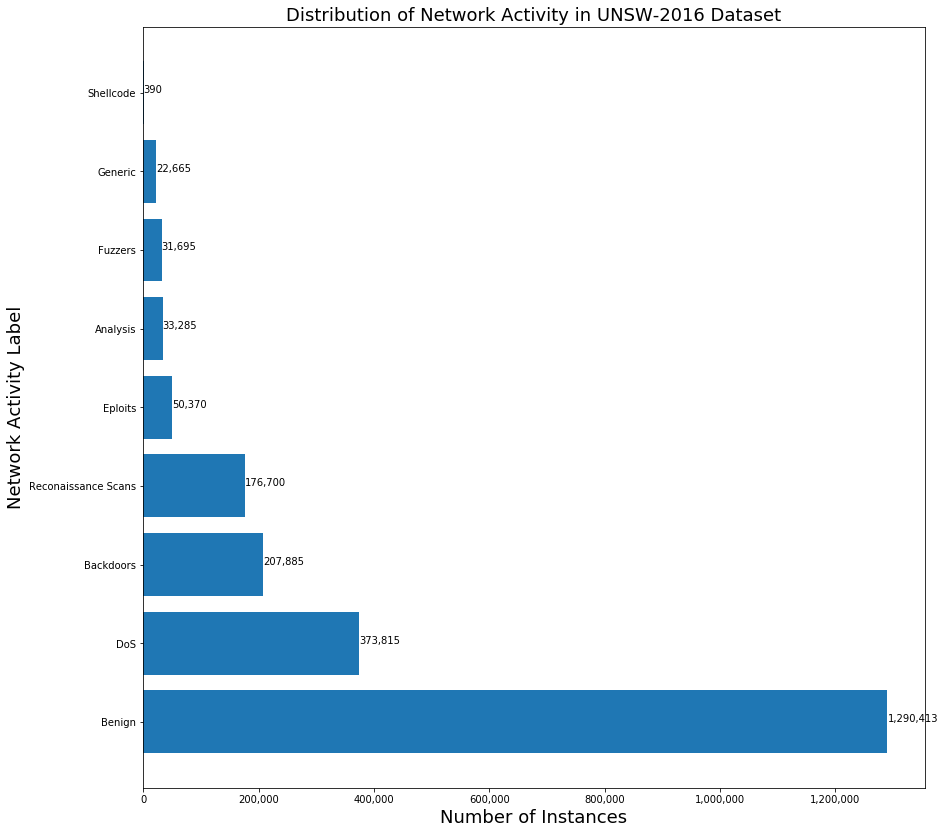

In [0]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
_ = ax.barh(flow_names, flow_frequencies)


for index, value in enumerate(flow_frequencies):
  _ = ax.text(value + 100, index, format(value, ","), color='black')
_ = plt.title("Distribution of Network Activity in UNSW-2016 Dataset", fontsize=18)

_ = plt.xlabel("Number of Instances", fontsize=18)
_ = plt.ylabel("Network Activity Label", fontsize=18)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# adjust x-tick limits
_ = plt.xticks(list(range(0, 1300413, 200000)))
_
# format x-tick labels with commas for readability
_ = ax.set_xticklabels(["{:,}".format(x) for x in ax.get_xticks()])
fig.savefig("./Figures/UNSW-dist.pdf", bbox_inches='tight')

In [0]:
CONT_FEATURE_SIZE = 38
## Normalize values
continuous_flows = np.array(continuous_flows)
print(continuous_flows.shape)
for i in range(0,CONT_FEATURE_SIZE):
  max_value = np.max(continuous_flows[:,i])
  min_value = np.min(continuous_flows[:,i])
  continuous_flows[:,i] = ((continuous_flows[:,i] - min_value)/(max_value-min_value +1e-12))
## Get different flows
benign_flows = continuous_flows[:NUM_BENIGN]
scan_flows = continuous_flows[NUM_BENIGN:NUM_BENIGN+NUM_SCAN]
fuzz_flows = continuous_flows[NUM_BENIGN+NUM_SCAN:NUM_BENIGN+NUM_SCAN+NUM_FUZZ]
analy_flows = continuous_flows[NUM_BENIGN+NUM_SCAN+NUM_FUZZ:NUM_BENIGN+NUM_SCAN+NUM_FUZZ+NUM_ANALY]
intermediate_total =NUM_BENIGN+NUM_SCAN+NUM_FUZZ+NUM_ANALY
back_flows = continuous_flows[intermediate_total:intermediate_total+NUM_BACK]
dos_flows = continuous_flows[intermediate_total+NUM_BACK:intermediate_total+NUM_BACK+NUM_DOS]
exp_flows = continuous_flows[intermediate_total+NUM_BACK+NUM_DOS:intermediate_total+NUM_BACK+NUM_DOS+NUM_EXP]
intermediate_total =intermediate_total +NUM_BACK+NUM_DOS+NUM_EXP
gen_flows = continuous_flows[intermediate_total:intermediate_total+NUM_GEN]
shell_flows = continuous_flows[intermediate_total+NUM_GEN:intermediate_total+NUM_GEN+NUM_SHELL]
worm_flows = continuous_flows[intermediate_total+NUM_GEN+NUM_SHELL:intermediate_total+NUM_GEN+NUM_SHELL+NUM_WORM]

(206273, 38)


In [0]:

from sklearn.utils import resample
## Cluster resample for the different types 
## of the flows
def cluster_resample(flows, num_clusters):
  NUM_SAMPLES = 5000
  sorted_flows = []
  for i in range(num_clusters):
    sorted_flows.append([])
  ## sort in num clusters ##
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(flows)
  labels = kmeans.predict(flows)
  centroids = kmeans.cluster_centers_
  for index in range(len(labels)):
    label_index = labels[index]
    sorted_flows[label_index].append(flows[index])

  resampled_flows = []
  for i in range(num_clusters):
    resampled_flows.append([])

  for i in range(num_clusters):
    resampled_flows[i] = resample(sorted_flows[i],
                                      replace=True, # sample with replacement
                                      n_samples=NUM_SAMPLES, # match number in majority class
                                      random_state=27) # reproducible results
  final_flows = []
  for i in range(num_clusters):
    for flow in resampled_flows[i]:
      final_flows.append(flow)  
  return final_flows

1
2
3
4
5
6
7
8
9
10


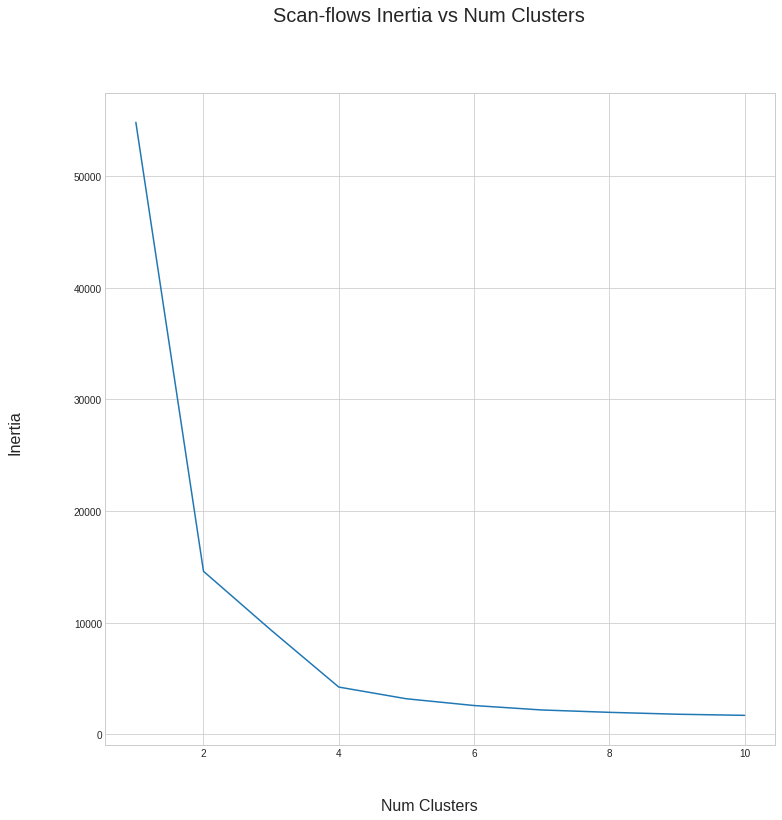

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering 
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(scan_flows)
  labels = kmeans.predict(scan_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_)   
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Scan")
_ = fig.suptitle('Scan-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-Scan-Inertia.pdf", bbox_inches='tight')


1
2
3
4
5
6
7
8
9
10


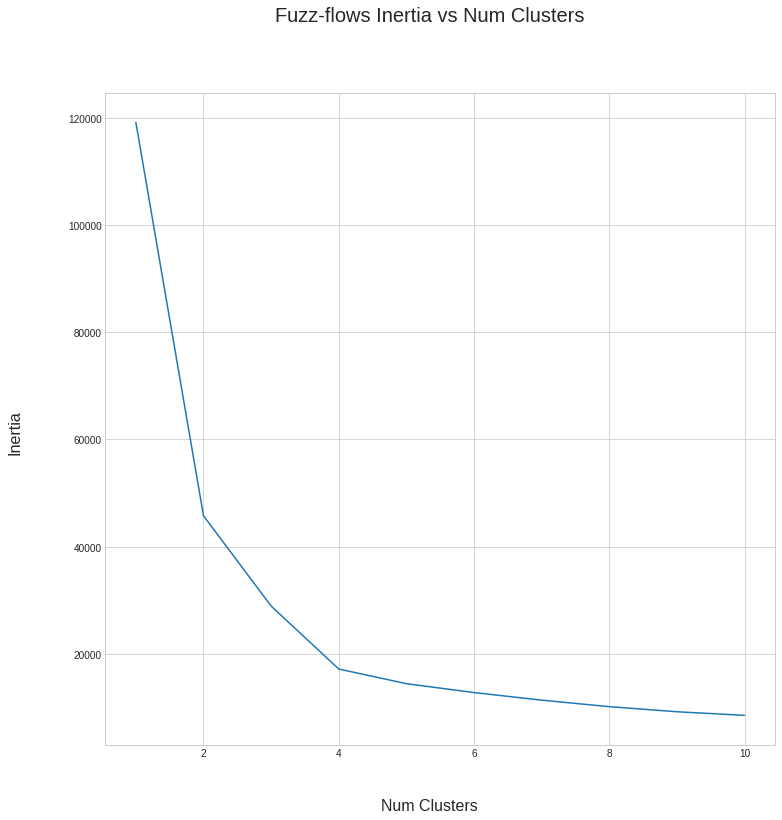

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering 
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(fuzz_flows)
  labels = kmeans.predict(fuzz_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_) 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Fuzz")
_ = fig.suptitle('Fuzz-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-Fuzz-Inertia.pdf", bbox_inches='tight')


In [0]:
final_fuzz_flows = cluster_resample(fuzz_flows, 4)

20000


1
2
3
4
5
6
7
8
9
10


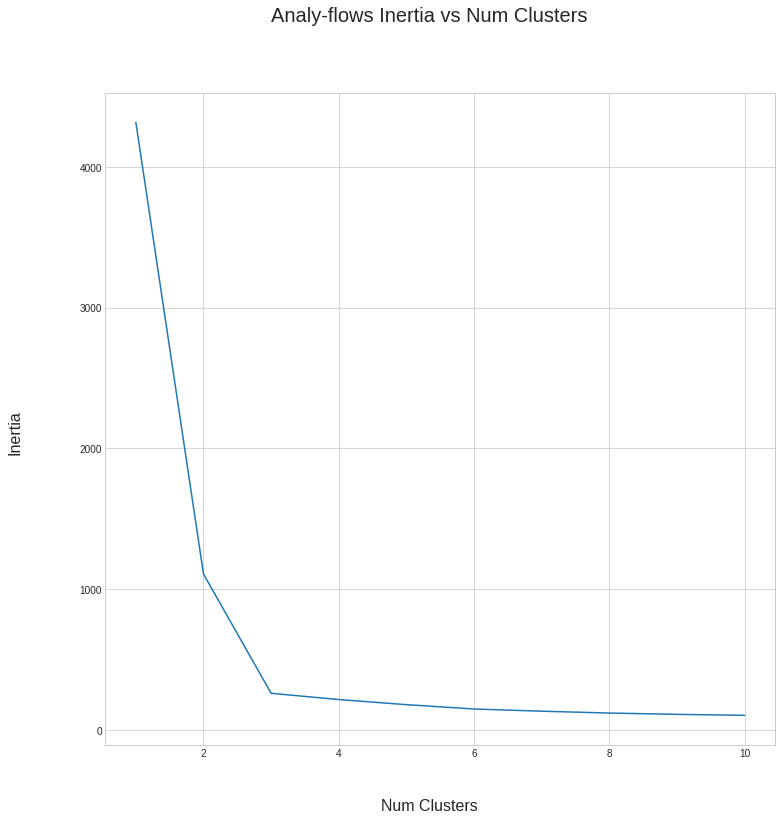

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering 
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(analy_flows)
  labels = kmeans.predict(analy_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_)   
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Fuzz")
_ = fig.suptitle('Analy-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-Analy-Inertia.pdf", bbox_inches='tight')


In [0]:
final_analy_flows = cluster_resample(analy_flows, 3)

1
2
3
4
5
6
7
8
9
10


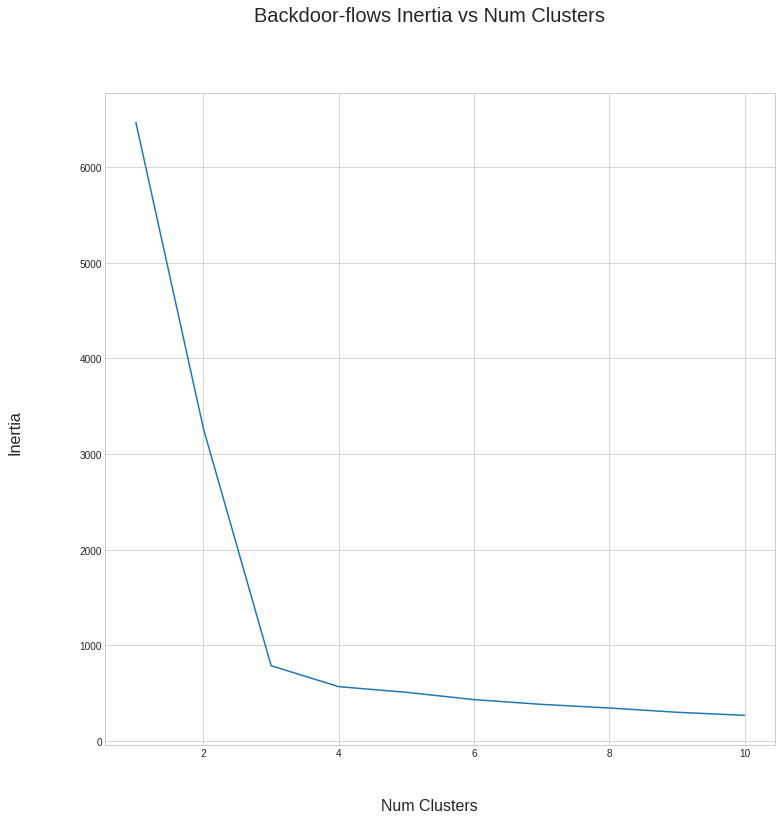

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering 
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(back_flows)
  labels = kmeans.predict(back_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_)   
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Fuzz")
_ = fig.suptitle('Backdoor-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-Backdoor-Inertia.pdf", bbox_inches='tight')


In [0]:
final_back_flows = cluster_resample(back_flows, 3)

1
2
3
4
5
6
7
8
9
10


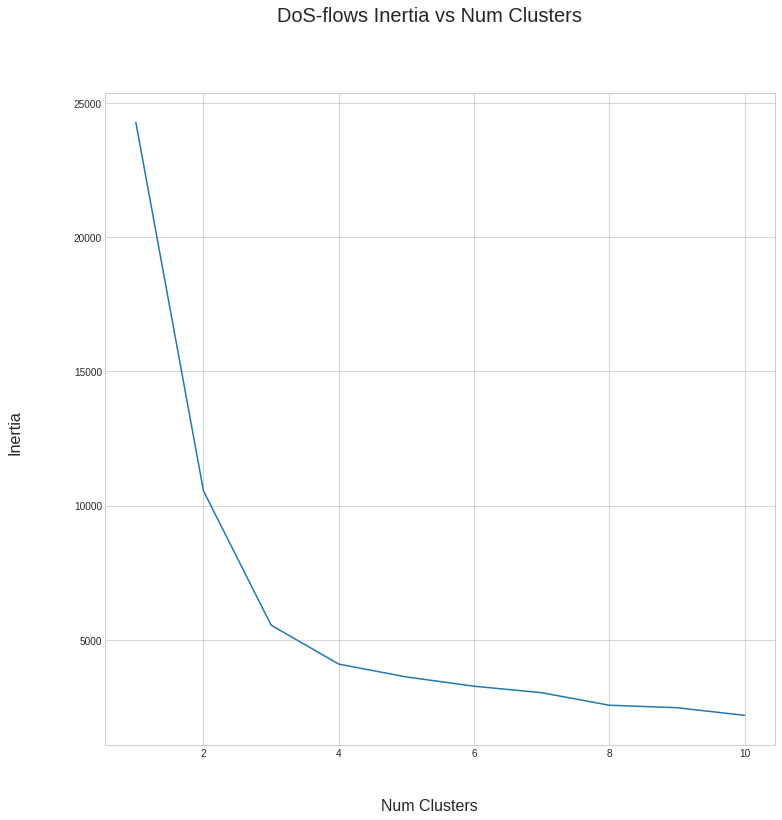

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(dos_flows)
  labels = kmeans.predict(dos_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_)  
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Fuzz")
_ = fig.suptitle('DoS-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-DoS-Inertia.pdf", bbox_inches='tight')


In [0]:
final_dos_flows = cluster_resample(dos_flows, 4)

20000


1
2
3
4
5
6
7
8
9
10


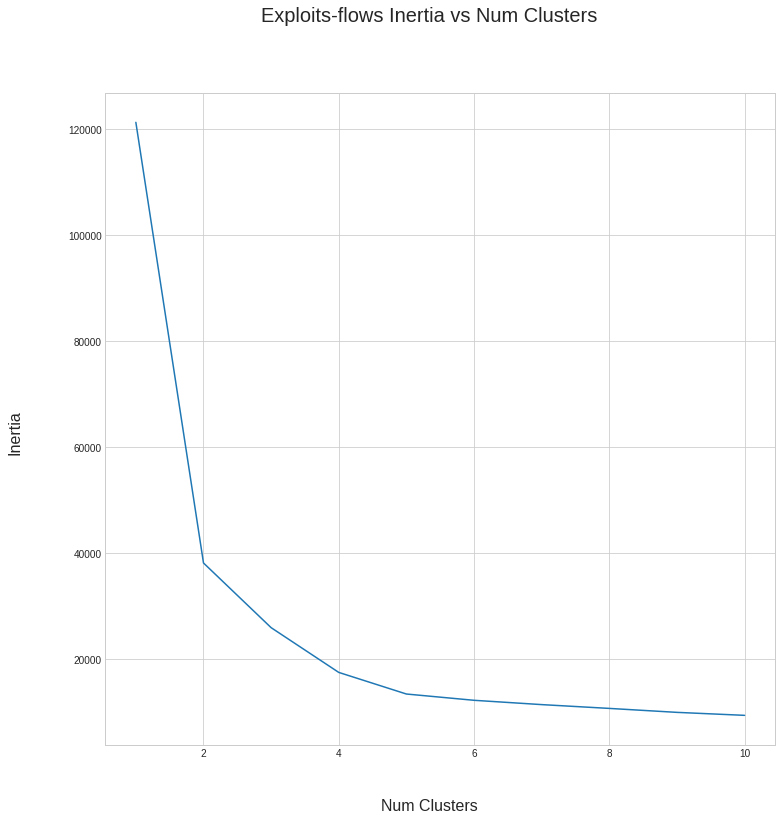

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering 
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(exp_flows)
  labels = kmeans.predict(exp_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_)    
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Fuzz")
_ = fig.suptitle('Exploits-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-Exploits-Inertia.pdf", bbox_inches='tight')


In [0]:
final_exp_flows = cluster_resample(exp_flows, 5)

25000


1
2
3
4
5
6
7
8
9
10


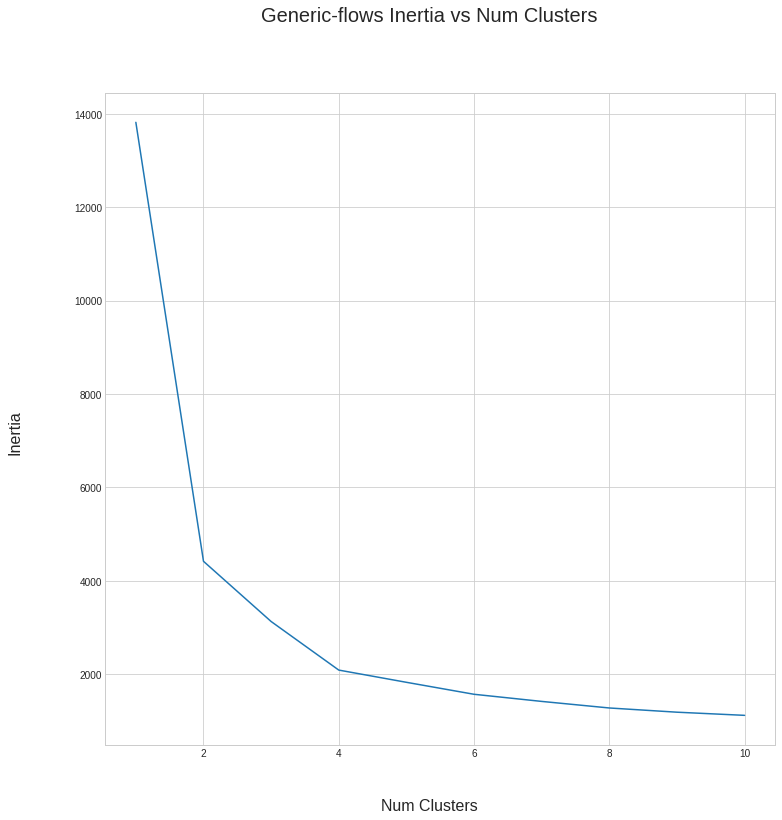

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering 
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(gen_flows)
  labels = kmeans.predict(gen_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_)   
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Gen")
_ = fig.suptitle('Generic-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-Gen-Inertia.pdf", bbox_inches='tight')


In [0]:
final_gen_flows = cluster_resample(gen_flows, 4)

20000


1
2
3
4
5
6
7
8
9
10


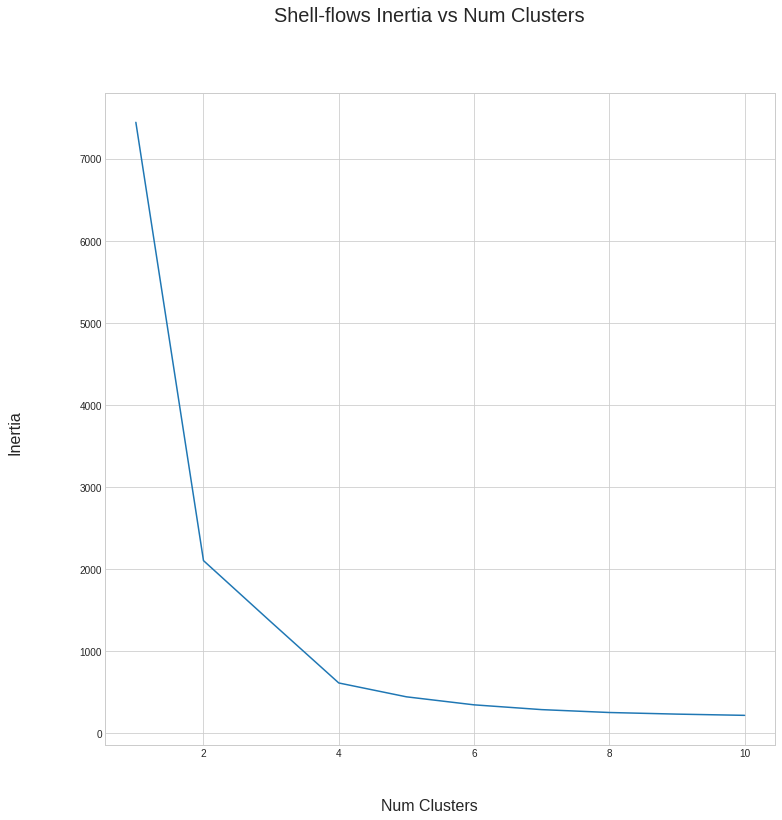

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering 
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(shell_flows)
  labels = kmeans.predict(shell_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_)   
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Shell")
_ = fig.suptitle('Shell-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-Shell-Inertia.pdf", bbox_inches='tight')


In [0]:
final_shell_flows = cluster_resample(shell_flows, 4)

20000


1
2
3
4
5
6
7
8
9
10


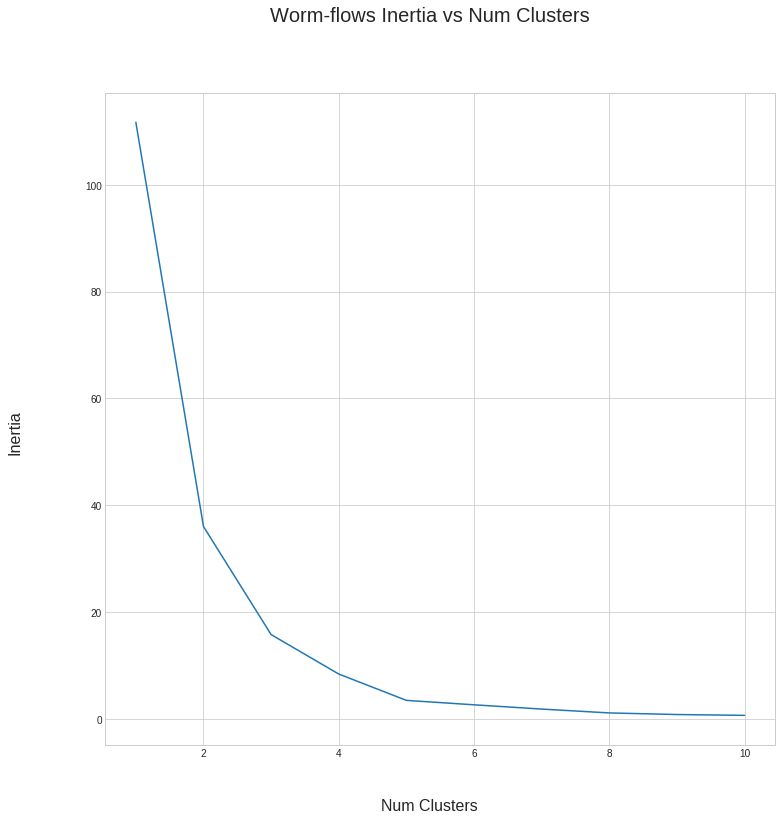

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from math import sqrt

## Get  Clustering 
num_clusters = []
rmses = []
for i in range(1,11):
  print(i)
  num_clusters.append(i)
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(worm_flows)
  labels = kmeans.predict(worm_flows)
  centroids = kmeans.cluster_centers_
  rmses.append(kmeans.inertia_)  
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(111)
_ = ax.plot(num_clusters, rmses, label="Shell")
_ = fig.suptitle('Worm-flows Inertia vs Num Clusters', fontsize=20)
_ = fig.text(0.5, 0.05, 'Num Clusters', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Inertia', ha='center', fontsize=16, rotation=90)
fig.savefig("./Figures/UNSW-Worm-Inertia.pdf", bbox_inches='tight')


In [0]:
NUM_SAMPLED = 1000
BENIGN_SAMPLED = 400
## Get Sampling for TSNE  Analysis
scan_index = np.random.choice(len(scan_flows), NUM_SAMPLED , replace=False)
fuzz_index = np.random.choice(len(fuzz_flows), NUM_SAMPLED , replace=False)
analy_index = np.random.choice(len(analy_flows), NUM_SAMPLED , replace=True)
back_index = np.random.choice(len(back_flows), NUM_SAMPLED , replace=True)
dos_index = np.random.choice(len(dos_flows), NUM_SAMPLED , replace=False)
exp_index = np.random.choice(len(exp_flows), NUM_SAMPLED , replace=False)
gen_index = np.random.choice(len(gen_flows), NUM_SAMPLED , replace=False)
worm_index = np.random.choice(len(worm_flows), NUM_SAMPLED , replace=True)
benign_index = np.random.choice(len(benign_flows), BENIGN_SAMPLED , replace=False)

SAMPLED_NUM_SCAN = NUM_SAMPLED
SAMPLED_NUM_FUZZ = NUM_SAMPLED
SAMPLED_NUM_ANALY = NUM_SAMPLED
SAMPLED_NUM_DOS = NUM_SAMPLED

SAMPLED_NUM_EXP = NUM_SAMPLED
SAMPLED_NUM_SHIFU = NUM_SAMPLED
SAMPLED_NUM_GEN = NUM_SAMPLED
SAMPLED_NUM_SHELL = NUM_SAMPLED

SAMPLED_NUM_WORM= NUM_SAMPLED
SAMPLED_NUM_BENIGN = BENIGN_SAMPLED

In [0]:
## Get Sampling for TSNE  Analysis
sampled_scan_flows =[]
sampled_fuzz_flows = []
sampled_analy_flows = []
sampled_back_flows = []
sampled_dos_flows =[]
sampled_exp_flows = []
sampled_gen_flows = []
sampled_shell_flows = []
sampled_worm_flows = []
sampled_benign_flows = []
for i in scan_index:
  sampled_scan_flows.append(scan_flows[i]) 
for i in fuzz_index:
  sampled_fuzz_flows.append(fuzz_flows[i]) 
for i in analy_index:
  sampled_analy_flows.append(analy_flows[i])  
for i in back_index:
  sampled_back_flows.append(back_flows[i])  
  
for i in dos_index:
  sampled_dos_flows.append(dos_flows[i]) 
for i in exp_index:
  sampled_exp_flows.append(exp_flows[i]) 
for i in gen_index:
  sampled_gen_flows.append(gen_flows[i])  
for i in worm_index:
  sampled_worm_flows.append(worm_flows[i])  
for i in benign_index:
  sampled_benign_flows.append(benign_flows[i])
  


In [0]:
## Get Sampling for TSNE  Analysis
benign_flows = continuous_flows[:NUM_BENIGN]
mal_flows = continuous_flows[NUM_BENIGN:]
NUM_SAMPLED = 1000
diff_benign_index = np.random.choice(len(benign_flows), NUM_SAMPLED , replace=False)
diff_mal_index = np.random.choice(len(mal_flows), NUM_SAMPLED , replace=False)

In [0]:
sampled_benign_flows =[]
sampled_mal_flows = []
for i in diff_benign_index:
  sampled_benign_flows.append(benign_flows[i])
for i in diff_mal_index:
  sampled_mal_flows.append(mal_flows[i])
all_flows = sampled_mal_flows+sampled_benign_flows

2000


In [0]:
from sklearn.manifold import TSNE
data_transformed = TSNE(n_components=2).fit_transform(all_flows)
benign_data_transformed = data_transformed[:NUM_SAMPLED]
mal_data_transformed = data_transformed[NUM_SAMPLED:]

BENIGN = {0: [x[0] for x in benign_data_transformed],
          1: [x[1] for x in benign_data_transformed]}

MALICIOUS = {0: [x[0] for x in mal_data_transformed],
             1: [x[1] for x in mal_data_transformed]}

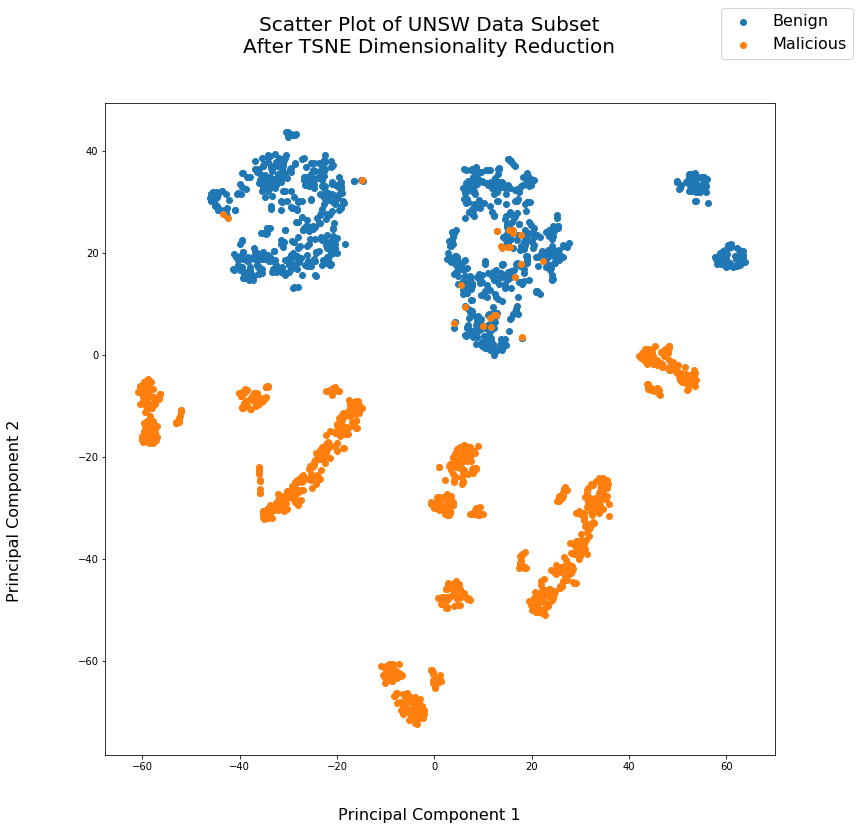

In [0]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
_ = ax.scatter(BENIGN[0], BENIGN[1], label="Benign")
_ = ax.scatter(MALICIOUS[0], MALICIOUS[1], label="Malicious")
_ = fig.suptitle('Scatter Plot of UNSW Data Subset\nAfter TSNE Dimensionality Reduction', fontsize=20)
_ = fig.text(0.5, 0.05, 'Principal Component 1', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'Principal Component 2', ha='center', fontsize=16, rotation=90)
_ = fig.legend(fontsize=16)
fig.savefig("./Figures/UNSW-HTTP-TSNE.pdf", bbox_inches='tight')

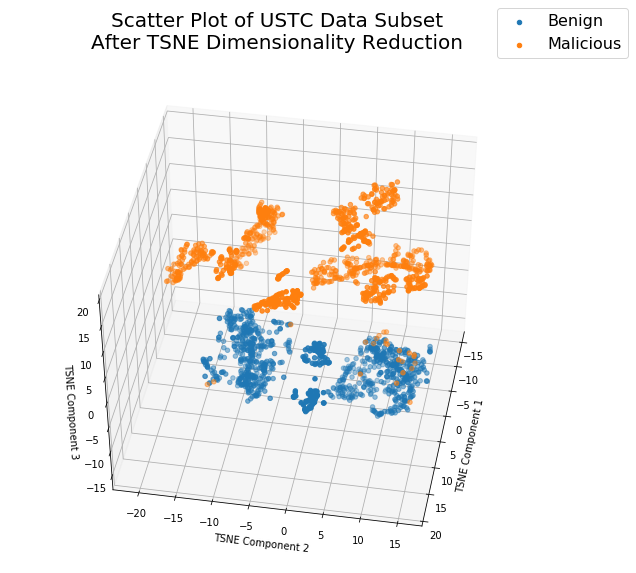

In [0]:
data_transformed = TSNE(n_components=3).fit_transform(all_flows)
benign_data_transformed = data_transformed[:NUM_SAMPLED]
malicious_data_transformed = data_transformed[NUM_SAMPLED:]
BENIGN = {0: [x[0] for x in benign_data_transformed],
          1: [x[1] for x in benign_data_transformed],
         2: [x[2] for x in benign_data_transformed]}

MALICIOUS = {0: [x[0] for x in malicious_data_transformed],
             1: [x[1] for x in malicious_data_transformed],
            2: [x[2] for x in malicious_data_transformed]}

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(45, 10)
ax.figure.set_size_inches(10, 9)
_ = ax.scatter(BENIGN[0], BENIGN[1],BENIGN[2], label="Benign")
_ = ax.scatter(MALICIOUS[0], MALICIOUS[1],MALICIOUS[2], label="Malicious")
_ = fig.suptitle('Scatter Plot of USTC Data Subset\nAfter TSNE Dimensionality Reduction', fontsize=20)
_ = ax.set_xlabel('TSNE Component 1')
_ = ax.set_ylabel('TSNE Component 2')
_ = ax.set_zlabel('TSNE Component 3')
_ = fig.legend(fontsize=16)

fig.savefig("./Figures/UNSW-HTTP-all-TSNE3D.pdf", bbox_inches='tight')

In [0]:
all_flows = list(sampled_scan_flows) +list(sampled_fuzz_flows)+ list(sampled_analy_flows) +list(sampled_back_flows)
all_flows = all_flows + list(sampled_dos_flows) + list(sampled_exp_flows)+ list(sampled_gen_flows)
all_flows = all_flows + list(sampled_shell_flows) + list(sampled_worm_flows) 

In [0]:
from sklearn.manifold import TSNE

data_transformed = TSNE(n_components=2).fit_transform(all_flows)
print(len(data_transformed))
NUM_SAMPLED = 1000

dt_scan_flows = data_transformed[:NUM_SAMPLED]
dt_fuzz_flows = data_transformed[NUM_SAMPLED:NUM_SAMPLED+NUM_SAMPLED]
dt_analy_flows = data_transformed[NUM_SAMPLED+NUM_SAMPLED:NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED]
total_index = NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED

dt_back_flows = data_transformed[total_index:total_index+NUM_SAMPLED]
dt_dos_flows = data_transformed[total_index+NUM_SAMPLED:total_index+NUM_SAMPLED+NUM_SAMPLED]
dt_exp_flows = data_transformed[total_index+NUM_SAMPLED+NUM_SAMPLED:total_index+NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED]
total_index = total_index+NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED
print(total_index)

dt_gen_flows = data_transformed[total_index:total_index+NUM_SAMPLED]
dt_worm_flows = data_transformed[total_index+NUM_SAMPLED+NUM_SAMPLED:total_index+NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED]


SCAN = {0: [x[0] for x in dt_scan_flows],
             1: [x[1] for x in dt_scan_flows]}

FUZZ = {0: [x[0] for x in dt_fuzz_flows],
             1: [x[1] for x in dt_fuzz_flows]}

ANALY = {0: [x[0] for x in dt_analy_flows],
             1: [x[1] for x in dt_analy_flows]}

BACK = {0: [x[0] for x in dt_back_flows],
             1: [x[1] for x in dt_back_flows]}

DOS = {0: [x[0] for x in dt_dos_flows],
             1: [x[1] for x in dt_dos_flows]}

EXP = {0: [x[0] for x in dt_exp_flows],
             1: [x[1] for x in dt_exp_flows]}

GEN = {0: [x[0] for x in dt_gen_flows],
             1: [x[1] for x in dt_gen_flows]}

# SHELL = {0: [x[0] for x in dt_shell_flows],
#              1: [x[1] for x in dt_shell_flows]}

WORM = {0: [x[0] for x in dt_worm_flows],
             1: [x[1] for x in dt_worm_flows]}

8000
6000


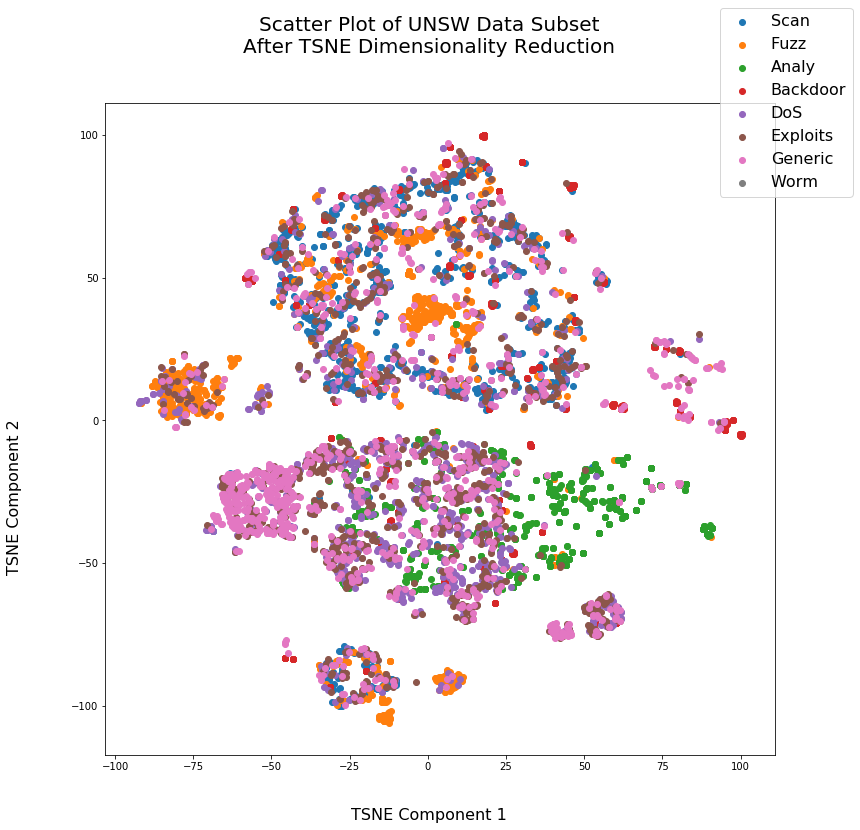

In [0]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
_ = ax.scatter(SCAN[0], SCAN[1], label="Scan")
_ = ax.scatter(FUZZ[0], FUZZ[1], label="Fuzz")
_ = ax.scatter(ANALY[0], ANALY[1], label="Analy")
_ = ax.scatter(BACK[0], BACK[1], label="Backdoor")
_ = ax.scatter(DOS[0], DOS[1], label="DoS")
_ = ax.scatter(EXP[0], EXP[1], label="Exploits")
_ = ax.scatter(GEN[0], GEN[1], label="Generic")
# _ = ax.scatter(SHELL[0], SHELL[1], label="Shell")
_ = ax.scatter(WORM[0], WORM[1], label="Worm")
_ = fig.suptitle('Scatter Plot of UNSW Data Subset\nAfter TSNE Dimensionality Reduction', fontsize=20)
_ = fig.text(0.5, 0.05, 'TSNE Component 1', ha='center', fontsize=16)
_ = fig.text(0.02, 0.5, 'TSNE Component 2', ha='center', fontsize=16, rotation=90)
_ = fig.legend(fontsize=16)

fig.savefig("./Figures/UNSW-HTTP-mal-TSNE.pdf", bbox_inches='tight')

In [0]:
all_flows = list(sampled_scan_flows) +list(sampled_fuzz_flows)+ list(sampled_analy_flows) +list(sampled_back_flows)
all_flows = all_flows + list(sampled_dos_flows) + list(sampled_exp_flows)+ list(sampled_gen_flows)
all_flows = all_flows + list(sampled_shell_flows) + list(sampled_worm_flows) 

In [0]:
data_transformed = TSNE(n_components=3).fit_transform(all_flows)
print(len(data_transformed))
NUM_SAMPLED = 1000

dt_scan_flows = data_transformed[:NUM_SAMPLED]
dt_fuzz_flows = data_transformed[NUM_SAMPLED:NUM_SAMPLED+NUM_SAMPLED]
dt_analy_flows = data_transformed[NUM_SAMPLED+NUM_SAMPLED:NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED]
total_index = NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED

dt_back_flows = data_transformed[total_index:total_index+NUM_SAMPLED]
dt_dos_flows = data_transformed[total_index+NUM_SAMPLED:total_index+NUM_SAMPLED+NUM_SAMPLED]
dt_exp_flows = data_transformed[total_index+NUM_SAMPLED+NUM_SAMPLED:total_index+NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED]
total_index = total_index+NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED

dt_gen_flows = data_transformed[total_index:total_index+NUM_SAMPLED]
dt_worm_flows = data_transformed[total_index+NUM_SAMPLED+NUM_SAMPLED:total_index+NUM_SAMPLED+NUM_SAMPLED+NUM_SAMPLED]


SCAN = {0: [x[0] for x in dt_scan_flows],
             1: [x[1] for x in dt_scan_flows],
       2: [x[2] for x in dt_scan_flows]}

FUZZ = {0: [x[0] for x in dt_fuzz_flows],
             1: [x[1] for x in dt_fuzz_flows],
       2: [x[2] for x in dt_fuzz_flows]}

ANALY = {0: [x[0] for x in dt_analy_flows],
             1: [x[1] for x in dt_analy_flows],
         2: [x[2] for x in dt_analy_flows]}

BACK = {0: [x[0] for x in dt_back_flows],
             1: [x[1] for x in dt_back_flows],
       2: [x[2] for x in dt_back_flows]}

DOS = {0: [x[0] for x in dt_dos_flows],
             1: [x[1] for x in dt_dos_flows],
       2: [x[2] for x in dt_dos_flows]}

EXP = {0: [x[0] for x in dt_exp_flows],
             1: [x[1] for x in dt_exp_flows],
      2: [x[2] for x in dt_exp_flows]}

GEN = {0: [x[0] for x in dt_gen_flows],
             1: [x[1] for x in dt_gen_flows],
      2: [x[2] for x in dt_gen_flows]}
WORM = {0: [x[0] for x in dt_worm_flows],
             1: [x[1] for x in dt_worm_flows],
       2: [x[2] for x in dt_worm_flows]}

8000
6000


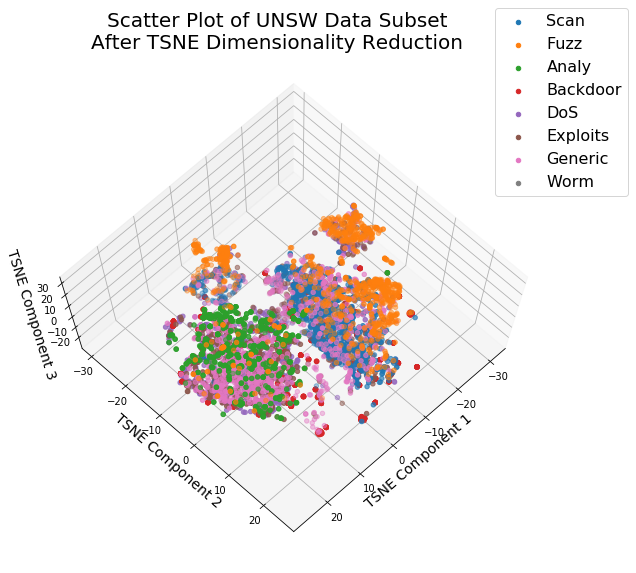

In [0]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(75, 45)
ax.figure.set_size_inches(10, 9)
_ = ax.scatter3D(SCAN[0], SCAN[1],SCAN[2], label="Scan")
_ = ax.scatter3D(FUZZ[0], FUZZ[1],FUZZ[2], label="Fuzz")
_ = ax.scatter3D(ANALY[0], ANALY[1],ANALY[2], label="Analy")
_ = ax.scatter3D(BACK[0], BACK[1],BACK[2], label="Backdoor")
_ = ax.scatter3D(DOS[0], DOS[1],DOS[2], label="DoS")
_ = ax.scatter3D(EXP[0], EXP[1],EXP[2], label="Exploits")
_ = ax.scatter3D(GEN[0], GEN[1],GEN[2], label="Generic")
_ = ax.scatter3D(WORM[0], WORM[1],WORM[2], label="Worm")
_ = fig.suptitle('Scatter Plot of UNSW Data Subset\nAfter TSNE Dimensionality Reduction', fontsize=20)
_ = ax.set_xlabel('TSNE Component 1')
_ = ax.set_ylabel('TSNE Component 2')
_ = ax.set_zlabel('TSNE Component 3')
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)
ax.zaxis.label.set_size(14)
_ = fig.legend(fontsize=16)

fig.savefig("./Figures/UNSW-HTTP-all-TSNE3D.pdf", bbox_inches='tight')